# Cluster the mission statements of the nonprofits

Take the not-for-profit organization name and/or their mission statement from  Form 990/Form 990N data and identify natural groupings to help categorize them.

For this, we only used charities in GA, IL, MI, MT, and NY. (And already it takes a while to run.)

## Setup

In [1]:
%matplotlib inline
import csv
import glob
import os
import re
import matplotlib.pyplot as plt
import numpy as np

from collections import Counter
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

plt.rcParams['figure.figsize'] = (12, 7)

## Load the data
Map the organization names and (if they exist) mission statements to the Nonprofit's Employer ID Number (EIN). The goal is to group similar organizations.

In [2]:
# Go through all of the entries from all of the Form 990 tax forms.
# We want
#  - the EIN number (to identify the business)
#  - their business name (because sometimes that's all there is)
#  - their mission statement(s)
state_paths = glob.glob(os.path.join('data', 'form990', '*'))
nfp_names = {}  # Map the EIN number to the business name
missions = {}  # Map the EIN number to the mission statement(s)

# We will also want a future lookup of state + city --> EIN
ein_state_city = {}

def get_city(path):
    return os.path.basename(path)[:-4]

for dirname in state_paths:
    cities_990 = glob.glob(os.path.join(dirname, '*'))
    # Set up to collect all of the EINs in a given state and city.
    state_abbr = os.path.basename(dirname)
    ein_state_city[state_abbr] = {}

    for fname in cities_990:
        city = get_city(fname)
        ein_state_city[state_abbr][city] = []
        with open(fname) as infile:
            rdr = csv.reader(infile, delimiter='\t')
            nfp_names_etc = [
                (row[0], row[2], row[27], row[-1], row[-2])
                for row in rdr
            ]
            nfp_names.update(dict(entry[:2] for entry in nfp_names_etc))
            missions.update(dict(
                    (entry[0], '  '.join(set(entry[1:])))  # remove duplicates
                    for entry in nfp_names_etc
            ))
            ein_state_city[state_abbr][city].extend(
                [row[0] for row in nfp_names_etc]
            )

## See a few of the entries

In [3]:
counter = 0
iterator = iter(missions.items())
while counter < 5:
    print(next(iterator))
    counter += 1

('', '')
('386107780', 'MICHIGAN PEO FUND INC    X')
('133843506', 'TZOFIM TZABAR: SCOUTING ACTIVITIES IN THE US  X  FRIENDS OF ISRAEL SCOUTS INC  SEE WWW.ISRAELSCOUTS.ORG')
('382928035', "Michigan Senior Olympics promotes healthy lifestyles by organizing state games, sports competitions and health, fitness, and wellness programs for active individuals 50 years plus  MICHIGAN SENIOR OLYMPICS INC  X  Michigan Senior Olympics promotes healthy lifestyles by organizing state games, sports competitions and health, fitness, and wellness programs for active individuals 50 years plus. Michigan Senior Olympics' vision is to provide all individuals 50 years plus with the programs to enjoy healthy and active lifestyles.")
('141997994', '  X  CATS IN THE CRADLE')


## Continue by loading the 990N data

In [4]:
# Also go through the Form 990N tax forms.
# We want
#  - the EIN number (to identify the business)
#  - their business name (there is no mission statement)
state_paths = glob.glob(os.path.join('data', 'form990N', '*'))
for dirname in state_paths:
    state_abbr = os.path.basename(dirname)
    if state_abbr not in ein_state_city:
        ein_state_city[state_abbr] = {}
    cities_990 = glob.glob(os.path.join(dirname, '*'))
    for fname in cities_990:
        city = get_city(fname)
        if city not in ein_state_city[state_abbr]:
            ein_state_city[state_abbr][city] = []
        with open(fname) as infile:
            rdr = csv.reader(infile, delimiter='\t')
            ein_to_name = dict((row[0], row[2]) for row in rdr)
            nfp_names.update(ein_to_name)
            # Missions too (use the name as the mission for 990Ns)...
            missions.update(ein_to_name)
            ein_state_city[state_abbr][city].extend(ein_to_name.keys())


del missions['']  # There was an empty EIN somewhere

## Group the Not-for-Profits by mission
1. Tokenize using the NLTK and scikit-learn text tools
2. Cluster using K-means
3. Look at what the clusters are and try and distinguish common features

In [5]:
# The tokenizer will split out words to help autogenerate
# 'tags' for the Nonprofit names/missions using the
# Natural Language Toolkit
custom_stopwords = stopwords.words('English') + [
    'x', 'association', 'club', 'institute', 'consortium', 'group',
    'incorporated', 'inc', 'llc', 'l3c', '&'
]
def tokenize(
        phrase,
        space_or_punct=re.compile("[\s,;:!\.]+"),
        stemmer=PorterStemmer(),
        stopwords=stopwords.words("English")):
    split_phrase = space_or_punct.split(phrase.lower())
    return set(stemmer.stem(word)
               for word in split_phrase
               if word not in stopwords and len(word))

In [6]:
#from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import k_means
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [7]:
sorted_nfps = sorted(missions.keys())
token_matrix = HashingVectorizer(
    tokenizer=tokenize,
    n_features=150
).transform([missions[ein] for ein in sorted_nfps])

### Try multiple cluster sizes to find some categorization that levels off
(This takes a really long time.)

In [8]:
mean_distances = {}
for k in range(5, 13):
    print('cluster size:', k)
    mean_distances[k] = k_means(token_matrix, k)[-1]

cluster size: 5
cluster size: 6
cluster size: 7
cluster size: 8
cluster size: 9
cluster size: 10
cluster size: 11
cluster size: 12


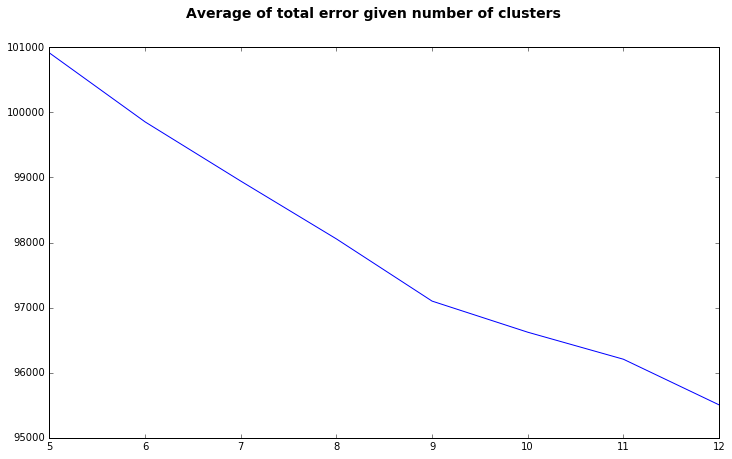

In [10]:
keys = list(mean_distances.keys())
ax = plt.plot(keys, [mean_distances[k] for k in keys])
__ = plt.suptitle(
    'Average of total error given number of clusters',
    fontweight='bold', fontsize=14)

### Well, nothing bottomed out.
Just pick a big number of clusters. Maybe I'll run the loop with more clusters later, but it takes over an hour.

In [11]:
num_clusters = 12
centers, labels, inertia =  k_means(token_matrix, num_clusters)

In [12]:
clustered_missions = {}
for label, ein in zip(labels, sorted_nfps):
    if label not in clustered_missions:
        clustered_missions[label] = [missions[ein]]
    else:
        clustered_missions[label].append(missions[ein])

word_counts = {}
for label, stmts in clustered_missions.items():
    print('~' * 20)
    print(label)
    print(len(stmts))
    word_counts[label] = Counter(
        [word.lower() for stmt in stmts for word in stmt.split()
         if word.lower() not in custom_stopwords]
    )
    print('\n'.join(stmts[:5]))
    print(word_counts[label].most_common(25)[-20:])

~~~~~~~~~~~~~~~~~~~~
0
14904
LULU VIOLET TEMPLE 1118
  ATLAS PIPELINE PARTNERS  TSUNIS FAMILY FOUNDATION INC
  EXCISE TAX REFUND  DANCING TIDES FOUNDATION INC C/O FLSV SETH STARR
  DC FILING FEE  MAAK FOUNDATION
  INVESTMENT & ADVISORY FEES  HUMAN GROWTH FOUNDATION
[('education', 870), ('bank', 818), ('expenses', 813), ('filing', 736), ('county', 724), ('fee', 595), ('extension', 523), ('income', 519), ('champaign', 484), ('charges', 483), ('co', 454), ('investment', 451), ('tax', 393), ('educational', 360), ('unrealized', 321), ('support', 306), ('school', 280), ('memorial', 263), ('j', 256), ('-', 256)]
~~~~~~~~~~~~~~~~~~~~
1
21605
Religious and Charitable Organization, formed and funded for the purpose of spreading the Christian religion and its beliefs both domestically and internationally.  Printing and distribution of a quarterly devotional called "The Word For You Today". These publications are distributed to shut-ins, prisoners, churches & others throughout the United States.  

## Apply tags, informed by the clustering

Not sure whether the time it took to cluster was worth it.
We did get things like music grouped together, financial/scholarship organizations together, and types of medical organizations grouped together, but I think I could have figured that out without clustering. The top-scoring tokens help with choosing phrases to match to the tags, thought.

From comments in the [pitch document][bundlekind-pitch]:

>We should align to an agreed upon core set of issues across the network, and stick to that. We've sort of been trying to align to the issues Code Corps has in their tool, but we should also talk to groups like Brand New Congress, Issue Voter, and any others with issue categories.


[bundlekind-pitch]: https://docs.google.com/document/d/1KEC3JhaJlIf7heexA8LtSaCuTGABYtvu_iRKC-Y0SLk

In [14]:
tags = dict(
    religious=['religi', 'christ', 'jesus', 'prayer', 'god', 'church', 'pastor', 'mission', 'mosque',
               'temple', 'abraham', 'faith', 'bibl', 'spiritual', 'meditation',
               'minist', 'jewish', 'hebrew', 'salvation', 'divin', 'holy', 'eternity',
               'catholic', 'sikh', 'buddhist', 'hindu', 'bahai', 'islam', 'hope', 'jain', 'atheis'],
    youth=['youth', 'child', 'kid', 'tot', 'camp', 'campus', 'play', 'motiv', 'girl',
           'boy', 'student', 'scout', '4h', 'mentor', 'minor', 'troop'],
    family=['family', 'husband', 'wive', 'wife', 'parent', 'marriage'],
    women=['women', 'woman', 'girl', 'ladies', 'daughter'],
    gender=['gender', 'lgbt'],
    sports=['sport', 'ath', 'fitness', 'hike', 'hiking', 'ball', 'little league', 'pop warner',
            'ski', 'skate', 'snow', 'rifle', 'hunt', 'fish', 'run', 'cycle', 'bike', 'swim',
            'equestrian', 'ice rink', 'tennis', 'hunt', 'bowling', 'gymnast', 'judo', 'soccer',
            'karate', 'kung', 'taek', 'yoga', 'rodeo', 'wrestl', 'double dutch',
            'lacrosse', 'budo', 'backpack'],
    education=['teach', 'educ', 'pta', 'learn', 'student', 'study', 'school',
               'grade', 'alumni', 'university', 'college', 'school', 'institute',
               'booster', 'scholar', 'academy', 'elementary',
               'literacy', 'library', 'toastmaster', 'debate', 'museum', 'planetarium'],
    health=['health', 'counseling', 'mental', 'medical', 'medicine', 'hospital', 'clinic',
            'doctor', 'nurse', 'parenthood', 'cancer', 'hospice', 'terminal', 'care',
            'red cross'],
    arts=['art', 'perform', 'choir', 'sing', 'choral', 'adelines', 'symphony',
          'orchest', 'danc', 'choreogra',
          'music', 'jazz', 'band', 'marching', 'ensemble', 'theat', 'movie',
          'film', 'cinema', 'poetry', 'poem', 'writ', 'paint', 'sculpt', 'ensemble',
          'cultural', 'literature', 'opera', 'broadway', 'production'],
    employment=['employm', 'train', 'vocation', 'job', 'work', 'skill'],
    nature=['nature', 'beautiful', 'animal', 'pet', 'horse', 'rescue', 'marine',
            'green', 'nature', 'tree','arbor', 'preserve', 'conserv', 'wolf',
            'eagle', 'outdoor', 'beach', 'trail', 'endangered', 'coast',
            'garden', 'park', 'mountain', 'lake', 'sanctuary', 'energy',
            'canal', 'creek'],
    rehabilitation=['prison', 'rehab', 'transitional house'],
    addiction=['addiction', 'drug', 'alcohol', 'aaa', 'overdose'],
    funding=['fund', 'foundation', 'charit', 'trust', 'invest', 'income', 'scholarship',
             'fellowship', 'financ', 'capital', 'gift'],
    media=['media', 'broadcast', 'telev', 'tv', 'radio', 'news', 'speech', 'publish',
           'publicat'],
    military=['veteran', 'vets', 'vfw', 'war', 'soldier', 'military', 'army', 'navy', 'guard',
              'force', 'squadron', 'battalion', 'corps'],
    elderly=['senior', 'home care', 'elderly', 'adult', 'retire', 'dementia', 'grandma', 'grandpa'],
    poverty=['poverty', 'poor', 'homeless', 'kitchen', 'food', 'pantry', 'low income',
             'habitat', 'thrift', 'goodwill', 'charity', 'need'],
    professional=['profession', 'union', 'worker', 'nurse', 'doctor', 'police', 'sheriff', 'fire',
                  'ist', 'bar ass', 'cemetery', 'pilot', 'commerce', 'employee',
                  'engineer', 'users', 'development', 'trade', 'barber', 'cosmetic',
                  'opportun', 'management', 'economic'],
    advocacy=['advocacy', 'lawyer', 'legal', 'defense', 'liberty', 'liberties', 'civil'],
    social=['social', 'daughter', 'son', 'brother', 'sister', 'men', 'women',
            'riders', 'motorcy', 'deaf', 'blind', 'immigr', 'refugee', 'association', 'assn',
           'family', 'community', 'neighbor', 'order', ],
    # Omit some greek letters because they're common subcomponents of other words
    greek=['fraternity', 'sorority', 'beta', 'gamma', 'delta', 'epsilon',
           'zeta', 'eta', 'theta', 'iota', 'kappa', 'lambda', 'xi', 'omicron',
           'rho', 'sigma', 'tau', 'upsilon', 'phi', 'chi', 'psi', 'omega'],
    first_peoples=['tribe', 'iroquois', 'cherokee', 'shawnee', 'teepee', ],
    charitable=['charit', 'kiwanis', 'rotary', 'legion', 'lodge', 'mason', 'jaycee',
            'lions', 'elks', 'optimist', 'moose', 'shriner', 'human', 'heritage', 'father',
            'mother', 'association', 'assoc', 'assn', 'service', 'club', 'society',
            'friend', 'knight', 'beautiful'],
    politics=['politi', 'campaign', 'vote', 'petiti', 'activis', 'grassroot', 'patriot', 'progressive'],
    farm=['farm', 'barn', 'agriculture', 'biofuel', 'ethanol'],
    technology=['tech', 'code', 'programming', 'computer', 'biofuel',
                'entrepreneur', 'enegy', 'advanced', 'future'],
    
)

In [15]:
tagged_missions = {}
unmatched = 0
no_mission = 0
for ein, mission in missions.items():
    if len(ein) == 0:  # Skipp the 
        continue
    tagged_missions[ein] = []
    lower_mission = mission.lower()
    if len(lower_mission) == 0:
        no_mission += 1
        continue
    for tag, matchers in tags.items():
        for m in matchers:
            if m in lower_mission:
                tagged_missions[ein].append(tag)
                break
    if len(tagged_missions[ein]) == 0:
        unmatched += 1

In [16]:
import json
import yaml

msg = '{} out of {} missions remain unmatched'
print(msg.format(unmatched, len(tagged_missions)))
print('{} missions have no statement at all'.format(no_mission))


# Make all directories if they don't exist
def setup_path(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)


# Write JSON objects containing the EINS and tags to file.
# Directory structure:
#   . tagged_eins
#   |-- <state-abbr>
#     |-- <city>.json
directory = os.path.join('data', 'tagged_eins')
setup_path(directory)
for state, city_lookups in ein_state_city.items():
    subdir = os.path.join(directory, state)
    setup_path(subdir)
    for city, selected_eins in city_lookups.items():
        eins_destination = os.path.join(subdir, city + '.json')
        tagged_subset = dict(
            (k, v) for k, v in tagged_missions.items()
            if k in selected_eins
        )
        with open(eins_destination, 'w') as outfile:
            outfile.write(json.dumps(tagged_subset))


# Save all of the tags
# Use YAML format so that non-coders can edit the tags list
tags_destination = os.path.join(directory, 'all_tags.yml')
with open(tags_destination, 'w') as outfile:
    yaml.dump(tags, outfile, default_flow_style=False)


print('Done.\nTagged files in:\n\t{}'.format(eins_destination))
print('Tags in:\n\t{}'.format(tags_destination))

10707 out of 116802 missions remain unmatched
26 missions have no statement at all
Done.
Tagged files in:
	data/tagged_eins/MT/Sheridan.json
Tags in:
	data/tagged_eins/all_tags.yml


## Count how many of each tag we have

In [17]:
tag_counts = Counter(
        [tag for tag_list in tagged_missions.values()
         for tag in tag_list]
    )

total_missions = len(tagged_missions)
for entry in tag_counts.most_common():
    tag, count = entry
    print('{:<14}'.format(tag), end='  ')
    print('{:2.0f}% ({})'.format(100 * count / total_missions, count))

social          41% (47562)
charitable      38% (44199)
funding         29% (33861)
professional    27% (31565)
education       26% (29897)
arts            22% (25887)
greek           18% (20979)
youth           14% (16884)
religious       14% (15987)
health          13% (15638)
sports          11% (12823)
nature          10% (11896)
employment      10% (11745)
poverty          8% (9072)
family           7% (8109)
military         7% (7662)
elderly          5% (5569)
technology       4% (4422)
women            3% (3864)
media            3% (2948)
advocacy         2% (2461)
politics         2% (1879)
rehabilitation   1% (1231)
farm             1% (1025)
addiction        1% (739)
gender           0% (267)
first_peoples    0% (118)


## Show some remaining unlabeled mission statements

In [18]:
counter = 0
iterator = iter(tagged_missions.items())
while counter < 200:
    ein, tag_list = next(iterator)
    if len(tag_list) == 0:
        print(missions[ein])
        counter += 1

POLISH NATIONAL ALLIANCE OF THE UNITED STATES OF NA
  DE SALES SOUTHWEST PROVINCE INC  X
WHATCOM COUNTY POMONA GRANGE NO 6
  X  PERCUSSIA
  GALLANT CHANCE RANCH INC  X
A BETTER BLASDELL
JONES BENEFIT INC
NYLON FUSION COLLECTIVE INC
ONE TO ONE
COLONIAL DAMES OF AMERICA
NORTHWEST BLOODHOUNDS
COLLINSVILLE TEPEE INC
  ROUNDING  MINNIE HETRICK TUW FBO ST JACOBS CH
SAVE THE PECONIC BAYS INC
ADIRONDACK PIPES AND DRUMS INCORPORATED
SANGAM PLACE
WINGS
  Adirondack Live Steamers Inc  X
TEENS FOR TEENS
  X  Stockbridge Boiler Room
Northwest Lymphedema Center  26499  
LET IT BE US
HAITIAN DOMINICAN GOOD SAMARITAN
STILLPOINT AT BECKSIDE
LIFEVINE INC
INDEPENDENT ZALESZCZYKER KRANKEN UNTERSHTITSUNGS VEREIN
  NEW YORK CITY H2O  X
  X  ITHACA FESTIVAL INC
AOAC INTERNATIONAL
  EXPENSES  BLUEGRASS FOR THE NEXT GENERATION PROJECT INC
THE INTERNATIONAL JUSTUS CORPORATION
LATINO RESOURCES NFP
ALOHA NOBLEHOUSE INC
  SUPPLIES FOR DREAMS INC  X
  PRESERVATION CASCADE INC  X
LES LIVE EVERY SECOND    NONE
HERRIN